In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy.stats as stats
import pymc3 as pm
import pandas as pd
import seaborn as sns
import arviz as az
from causalgraphicalmodels import CausalGraphicalModel

# Chapter 8 - CONDITIONAL MANATEES

## End of Chapter Problems

8E1. For each of the causal relationships below, name a hypothetical third variable that would lead
to an interaction effect.

(1) Bread dough rises because of yeast.

(2) Education leads to higher income.

(3) Gasoline makes a car go.

Answer: 

1) Temperature as a third variable would lead to an interaction effect with the yeast. Presumably fairly non-linear. Temperature would increase the impact of yeast on bread rising, but only up to a point. Beyond this point, temperature would start to kill the yeast, and probably fairly abruptly.

2) Peer group at 17 years old. Presumably this interaction would go in both directions. Having a network of friends who are into academic things would presumably bolster your academic performance, and having a good academic education is probably going to make it more likely that you would have this kind of peer group. Similarly, both of these things increase the likelihood that you would have better career outcomes, and due to the impacts of social capital on life outcomes, presumably education and your adult peer network interact in some way.

3) Strange one. Mundane variable about whether the ignition of the car has been used would interact with gasoline. In words, the interaction could be something like: The degree to which the car goes, given that it's got gasoline, depends on ignition use. Conversley, given the ignition has been used the degree to which the car go will varys depending on gasoline being in the car.


8E2. Which of the following explanations invokes an interaction?

(1) Caramelizing onions requires cooking over low heat and making sure the onions do not
dry out.

(2) A car will go faster when it has more cylinders or when it has a better fuel injector.

(3) Most people acquire their political beliefs from their parents, unless they get them instead
from their friends.

(4) Intelligent animal species tend to be either highly social or have manipulative appendages
(hands, tentacles, etc.).


Answer: 

1) The degree of caramelizing depends on both factors intreacting. If you just let the heat go up, and they dry out, then it won't caramelize

2) Each of these effects on the car is independent of the other, and there's no reason to think the synnergy is going to be more than the sum of the parts

3) Interaction. Increasing the influence of friends will decrease the influence of parents and vice versa. It's plausible that this could even be modelled quite well by a symmetric interaction

4) Unsure how to parse this one

8E3. For each of the explanations in 8E2, write a linear model that expresses the stated relationship.

Answer: Let's just stick with the basic linear symmetric interaction paradigm for this model.

1)  $\mu_i = \alpha + \beta_H H_i + \beta_D D_i + \beta_{HD}H_i D_i $

$\beta_{HD}$ will be positive to some degree. Why? because $\beta_H$ will be negative, increasing the heat, should reduce the amount of impact that dryness will have, as extreme heat will make caramelization virtually impossible.

2)  $\mu_i = \alpha + \beta_C C_i + \beta_I I_i $

No intercation

3)  $\mu_i = \alpha + \beta_P P_i + \beta_F F_i + \beta_{PF}F_i P_i $

$\mu$ is the mean of the variable describing how close you are to your parents belief at the high end and friends at the low end.
Let's say that $\beta_P$ and $\beta_F$ are the effect size of exposure to parents and friends political beliefs respectively. For simplicity, assume large exposure swings you more towards the influencing group. So $\beta_P$ would be positive in this setup and $\beta_F$ negative.

$\beta_{FP}$ should be a negative interaction effect as you could imagine that increasing time spent with friends would moderate the impact that time spent would parents would have, and vice versa. Symmetry in the interaction is nice in this toy model because the friends and the parents are all competing for time with you.

(4) This one is soo weird. I'm unsure how I'd write that interaction term down

8M1. Recall the tulips example from the chapter. Suppose another set of treatments adjusted the
temperature in the greenhouse over two levels: cold and hot. The data in the chapter were collected
at the cold temperature. You find none of the plants grown under the hot temperature developed
any blooms at all, regardless of the water and shade levels. Can you explain this result in terms of
interactions between water, shade, and temperature?

Answer: One imagines that there would be something like a 3-way interaction between all 3 and separate pairwise interactions between the variables, as this would allow each direction of the interactions to impact one another to different degrees.

8M2. Can you invent a regression equation that would make the bloom size zero, whenever the
temperature is hot?

In general the three way interaction would look something like this:

$\mu_i = \alpha + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_{12} x_1x_2 + \beta_{13} x_1x_3 + \beta_{23} x_12x_3 + \beta_{123} x_1x_2x_3$

Imagining using a temperature scale ranging from 0 to 1, 1 being a the hot end of the scale. When the temperature reaches 1, then the following equation would ensure that the mean bloom is zero when the temperature is zero.

$\mu_i = \alpha_2 - \alpha_2 T + (\beta \alpha_1  + \beta \beta_S S + \beta \beta_{W} W +\beta \beta_{SW}S W)  - T(\beta \alpha_1  + \beta \beta_S S + \beta \beta_{W} W +\beta \beta_{SW}S W) $

This can be further massaged to fit the general framework, but I leave that out here.

8.3 Too open ended for now

8M4. Repeat the tulips analysis, but this time use priors that constrain the effect of water to be positive and the effect of shade to be negative. Use prior predictive simulation. What do these prior
assumptions mean for the interaction prior, if anything?

In [33]:
Tulip = pd.read_csv("./data/tulips.csv", delimiter=";")

Answer: So we use precisely the same model as model m8.5 in the text, except I'll be using expontential random variables for the prior distributions to impose the constraints mentioned in the question. Why the exponential? I considered the log-normal, but this seemed far too week over the ranges considered. Using an exponential witha range 0.25 seems far more sensible. There is the unusual quirk of the exponential random variable in that it has the same mean and standard deviation. Thus in picking a $\lambda$ value for your prior distribution, you're simultanteously making a statement about the expeted value of the parameter and the range of values you expect it to take. This might not always be reasonable, but at least in the current situation, picking $\lambda = 0.5$ doesn't seem crazy, as it's: Constrained to be positivve; relavtively broad over the range of association strengths in the data; Yet it still expects that strenght of association to be less than 1 around 80% of the time (look up the cdf of the exponential random variable to get what I mean here).

NB: To impose the negative constrain, I make the coefficient of the shade negative in the mean line itself

In [34]:
#make the unit transformations found in the book
Tulip["s_blooms"] = Tulip.blooms.values/np.max(Tulip.blooms.values)
Tulip["s_water"] = Tulip.water - np.mean(Tulip.water)
Tulip["s_shade"] = Tulip.shade - np.mean(Tulip.shade)

In [35]:
with pm.Model() as Bloom:
    alpha = pm.Normal("alpha",0,0.2)#alpha prior
    beta= pm.Exponential("beta",2, shape = 2)#beta prior
    betaWS = pm.Normal("betaWS",0,0.25, )#interation prior
    sigma = pm.Exponential("sigma",1)
    mu = alpha + beta[0]*Tulip.s_water - beta[1]*Tulip.s_shade + betaWS*Tulip.s_shade.values*Tulip.s_water.values
    rev = pm.Normal("rev", mu=mu,sd=sigma,observed=Tulip.s_blooms)
    prior_sample = pm.sample_prior_predictive(samples=500)
    #first_sample = pm.sample(draws=500, chains=4)
    

In [66]:
Tulip.s_shade.drop_duplicates()

0   -1.0
1    0.0
2    1.0
Name: s_shade, dtype: float64

In [67]:
#Handy function for plotting the lines
def line(alpha,beta1,beta2,beta12):
    return lambda x1,x2 : alpha + x1*beta1 - x2*beta2 + x1*x2*beta12

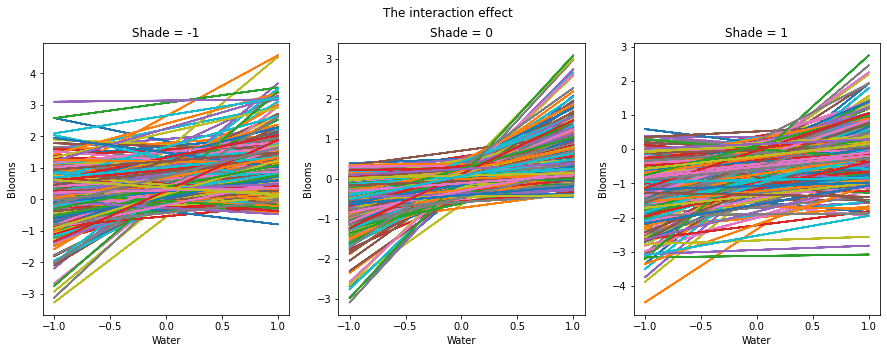

In [74]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
plt.suptitle("The interaction effect", fontsize=12)

for a,b1,b2,b12 in zip(prior_sample["alpha"],prior_sample["beta"][:,0],prior_sample["beta"][:,1],prior_sample["betaWS"]):
    axs[0].plot(Tulip.s_water, line(a,b1,b2,b12)(Tulip.s_water,-np.ones(Tulip.shape[0])))
    axs[1].plot(Tulip.s_water, line(a,b1,b2,b12)(Tulip.s_water,0))
    axs[2].plot(Tulip.s_water, line(a,b1,b2,b12)(Tulip.s_water,np.ones(Tulip.shape[0])))

axs[0].set_title("Shade = -1")
axs[1].set_title("Shade = 0")
axs[2].set_title("Shade = 1")

axs[0].set_xlabel("Water")
axs[1].set_xlabel("Water")
axs[2].set_xlabel("Water")

axs[0].set_ylabel("Blooms")
axs[1].set_ylabel("Blooms")
axs[2].set_ylabel("Blooms")

plt.show()

It's hard to unravel how impactful the interaction is on the prior as the lines are so scattered. Ofcourse, the prior now prohibits negative relationships between water and blooms and that is reflecteed in the priors. However it's really hard to 

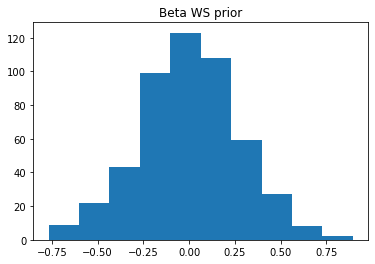

In [76]:
plt.title("Beta WS prior")
plt.hist(prior_sample["betaWS"])
plt.show()

The prior is broadly symmetric. This changes imposed shouldn't mean anything for the interaction prior. Firstly, I didn't change a thing about the model that would impact this explicitly. If you were to think harder about this then would it really change anything? I don't think so

8H1. Return to the data(tulips) example in the chapter. Now include the bed variable as a predictor in the interaction model. Don’t interact bed with the other predictors; just include it as a main
effect. Note that bed is categorical. So to use it properly, you will need to either construct dummy
variables or rather an index variable, as explained in Chapter 5.


Answer: pymc3 lets you vectorise the categorical variable parameters quite nicely.

In [4]:
#map the bed categories to an index
ind = Tulip.bed.astype("category").cat.codes

In [5]:
with pm.Model() as Categorical_Bloom:
    alpha = pm.Normal("alpha",0,0.2)#alpha prior
    beta = pm.Normal("betaWS",0,0.25,shape = (3,3) )#beta priors
    sigma = pm.Exponential("sigma",1)
    mu = alpha + beta[0,ind]*Tulip.s_water + beta[1,ind]*Tulip.s_shade + beta[2,ind]*Tulip.s_shade.values*Tulip.s_water.values
    rev = pm.Normal("rev", mu=mu,sd=sigma,observed=Tulip.s_blooms)
    #prior_sample = pm.sample_prior_predictive(samples=500)
    Cat_bloom_sample = pm.sample(draws=500, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, betaWS, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 5 seconds.


8H2. Use WAIC to compare the model from 8H1 to a model that omits bed. What do you infer
from this comparison? Can you reconcile the WAIC results with the posterior distribution of the bed
coefficients?

Answer: The model below is identical to the interaction model in the chapter

In [6]:
with pm.Model() as m8_5:
    alpha = pm.Normal("alpha",0,0.2)#alpha prior
    beta = pm.Normal("beta",0,0.25, shape=3)#interation prior
    sigma = pm.Exponential("sigma",1)
    mu = alpha + beta[0]*Tulip.s_water + beta[1]*Tulip.s_shade + beta[2]*Tulip.s_shade.values*Tulip.s_water.values
    rev = pm.Normal("rev", mu=mu,sd=sigma,observed=Tulip.s_blooms)
    #prior_sample = pm.sample_prior_predictive(samples=500)
    bloom_sample = pm.sample(draws=500, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 3 seconds.


In [17]:
df_comp_WAIC = pm.compare({'Categorical_Bloom': Cat_bloom_sample, 'm8_5': bloom_sample}, ic="WAIC")
df_comp_WAIC

/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:1413: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m8_5,0,12.289,4.443,0,0.696829,2.92848,0,True,log
Categorical_Bloom,1,10.967,7.09896,1.32203,0.303171,3.37612,1.86528,True,log


The simpler model from the chapter performed better than the one which included the bed categorical variables inside the model.

In [18]:
pm.summary(bloom_sample).T

/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,alpha,beta[0],beta[1],beta[2],sigma
mean,0.350,0.205,-0.113,-0.142,0.144
sd,0.028,0.034,0.036,0.042,0.023
hdi_3%,0.301,0.139,-0.184,-0.219,0.102
hdi_97%,0.407,0.266,-0.047,-0.068,0.185
mcse_mean,0.001,0.001,0.001,0.001,0.001
mcse_sd,0.000,0.000,0.000,0.001,0.000
ess_mean,2511.000,2361.000,2916.000,2246.000,1477.000
ess_sd,2505.000,2361.000,2916.000,2246.000,1450.000
ess_bulk,2521.000,2419.000,3011.000,2268.000,1518.000
ess_tail,1288.000,1395.000,1775.000,1394.000,1393.000


In [14]:
#inspect the bed model posterior
pm.summary(Cat_bloom_sample).T

/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,alpha,"betaWS[0,0]","betaWS[0,1]","betaWS[0,2]","betaWS[1,0]","betaWS[1,1]","betaWS[1,2]","betaWS[2,0]","betaWS[2,1]","betaWS[2,2]",sigma
mean,0.350,0.148,0.223,0.229,-0.037,-0.191,-0.099,-0.128,-0.106,-0.173,0.141
sd,0.026,0.056,0.055,0.059,0.058,0.056,0.056,0.065,0.068,0.067,0.025
hdi_3%,0.300,0.037,0.120,0.112,-0.139,-0.298,-0.206,-0.249,-0.230,-0.304,0.100
hdi_97%,0.400,0.242,0.325,0.335,0.074,-0.088,0.004,-0.001,0.022,-0.054,0.189
mcse_mean,0.000,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
mcse_sd,0.000,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
ess_mean,3260.000,2459.000,2996.000,2756.000,2679.000,2260.000,3004.000,3403.000,2684.000,2693.000,1139.000
ess_sd,3260.000,2170.000,2937.000,2562.000,1435.000,2084.000,2259.000,2877.000,2012.000,2485.000,1139.000
ess_bulk,3373.000,2409.000,3038.000,2817.000,2688.000,2252.000,3031.000,3381.000,2694.000,2683.000,1052.000
ess_tail,1218.000,1428.000,1680.000,1361.000,1339.000,1546.000,1273.000,1596.000,1460.000,1635.000,1158.000


Introducing indexed effect sizes for each bed category introduces a lot of variables, which estimates of predictive accuracy penalise. This penality is overcome if there's a lot of gained predictive power coming out of the additional variables. Looking at the posterior summary for the bed variables however indicates that many of the additional parameters are consistent with being close to having zero predictive acurracy. Thus using the bed model seems to introduce further uncertainty into our model without the compensatory increase in predictive power.

8H3. Consider again the data(rugged) data on economic development and terrain ruggedness,
examined in this chapter. One of the African countries in that example, Seychelles, is far outside
the cloud of other nations, being a rare country with both relatively high GDP and high ruggedness.
Seychelles is also unusual, in that it is a group of islands far from the coast of mainland Africa, and
its main economic activity is tourism.

(a) Focus on model m8.5 from the chapter. Use WAIC pointwise penalties and PSIS Pareto k
values to measure relative influence of each country. By these criteria, is Seychelles influencing the
results? Are there other nations that are relatively influential? If so, can you explain why?

(b) Now use robust regression, as described in the previous chapter. Modify m8.5 to use a
Student-t distribution with ν = 2. Does this change the results in a substantial way?

Answer: 

He says m8.5 in the book. I think he must mean m8.3, as m8.5 is the tulip model, whilst m8.3 is for the country data, where the model uses different slopes and intercepts depending upon whether you are inside or outside of Africa - $\mu_i = \alpha_{CID[i]} + \beta_{CID[i]}(r_i-\bar{r})$ - CID[i] being the categorical indicator variable.

In [53]:
Rugged = pd.read_csv("./data/rugged.csv", delimiter=";")

In [60]:
#pre shape check
Rugged.shape

(234, 51)

In [58]:
#get the complete cases 
Complete = Rugged.dropna(axis=0, subset=["rgdppc_2000"])

In [62]:
#compare shape after dropping the Nans
Complete.shape

(170, 51)

In [66]:
#lets standardise the variables like how he does in the book
Complete["log_gdp"] = np.log(Complete["rgdppc_2000"])
Complete["s_log_gdp"] = Complete["log_gdp"]/np.mean(Complete["log_gdp"])
Complete["s_rugged"] = Complete["rugged"]/np.max(Complete["rugged"])

<ipython-input-66-48819bad8701>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Complete["log_gdp"] = np.log(Complete["rgdppc_2000"])
<ipython-input-66-48819bad8701>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Complete["s_log_gdp"] = Complete["log_gdp"]/np.mean(Complete["log_gdp"])
<ipython-input-66-48819bad8701>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

Now we've standardised the data, let's reimplement model m8.3, the interaction model from the book.

In [324]:
with pm.Model() as m8_3:
    alpha = pm.Normal("alpha", 1,0.1, shape = 2)#alpha prior
    beta = pm.Normal("beta", 1,0.3, shape = 2)#beta prior
    sigma = pm.Exponential("sigma", 1)
    mu = alpha[Complete.cont_africa] + beta[Complete.cont_africa]*(Complete.s_rugged - 0.215)
    l_gdp = pm.Normal("l_gdp", mu=mu, sd= sigma, observed=Complete.s_log_gdp)
    m8_3_samples = pm.sample(draws= 250, chains = 4)
    m8_3_post_samples = pm.sample_posterior_predictive(trace = m8_3_samples,samples= 100)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 3 seconds.
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/pymc3/sampling.py:1707: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [239]:
pm.summary(m8_3_samples)

/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],1.050,0.010,1.032,1.069,0.000,0.000,1359.0,1359.0,1359.0,836.0,1.00
alpha[1],0.888,0.016,0.860,0.920,0.000,0.000,1418.0,1407.0,1417.0,862.0,1.00
beta[0],-0.108,0.055,-0.210,-0.004,0.001,0.001,1928.0,1544.0,1896.0,806.0,1.01
beta[1],0.197,0.076,0.034,0.322,0.002,0.002,1501.0,1250.0,1513.0,760.0,1.00
sigma,0.112,0.006,0.101,0.124,0.000,0.000,1737.0,1720.0,1738.0,949.0,1.00


The parameter means and standard deviations match well with those given in the book (though the indices are exchanged).

We have our model, so let's plot it. First let's check the model implemented above reproduces what was done in the book.

/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


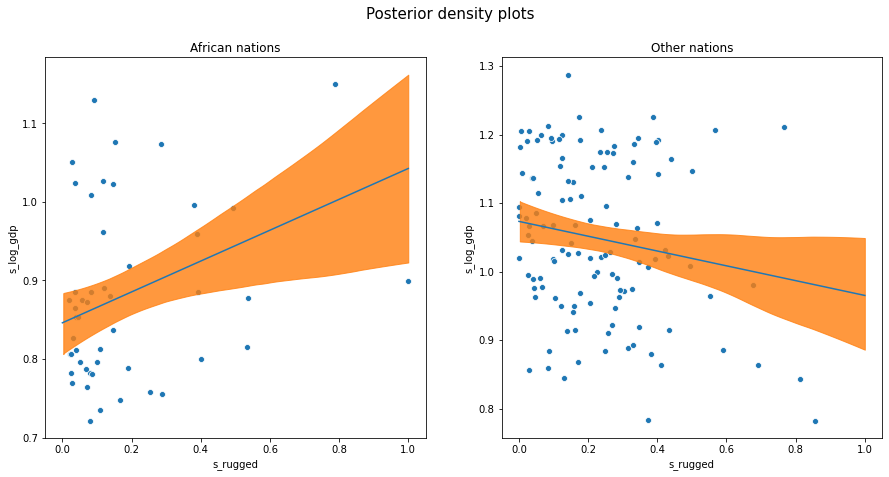

In [275]:
fig, axs = plt.subplots(1,2,figsize=(15,7))

fig.suptitle("Posterior density plots", fontsize=15)

x = np.linspace(0,1)

sns.scatterplot(x="s_rugged", y="s_log_gdp", data=Complete[Complete.cont_africa==1], ax=axs[0])
#get the average posterior
mu1 = m8_3_samples["alpha"][:,1] + np.outer(x-0.215,m8_3_samples["beta"][:,1])
axs[0].plot(x, np.mean(mu1,axis=1))
az.plot_hpd(
    x,
    mu1.T,
    ax=axs[0],
    fill_kwargs={"alpha": 0.8, "label": "Mean outcome 94% HPD"},
)
axs[0].set_title("African nations")


sns.scatterplot(x="s_rugged", y="s_log_gdp", data=Complete[Complete.cont_africa==0], ax=axs[1])
mu2 = m8_3_samples["alpha"][:,0] + np.outer(x-0.215,m8_3_samples["beta"][:,0])
axs[1].plot(x, np.mean(mu2,axis=1))
az.plot_hpd(
    x,
    mu2.T,
    ax=axs[1],
    fill_kwargs={"alpha": 0.8, "label": "Mean outcome 94% HPD"},
)
axs[1].set_title("Other nations")

plt.show()

In [277]:
#compute the waic and psis on the deviance scale
m8_3_waic = az.waic(m8_3_samples, pointwise=True, scale="deviance")
m8_3_LOO = az.loo(m8_3_samples, pointwise=True, scale="deviance")

/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:1413: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [283]:
#get the pointwise values for these distributions
pareto_k = m8_3_LOO.pareto_k.values

In [290]:
pareto_k.max()

0.6600385219580095

In [313]:
#get the places with the biggish pareto_k values
big = Complete[pareto_k >= 0.5]

/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


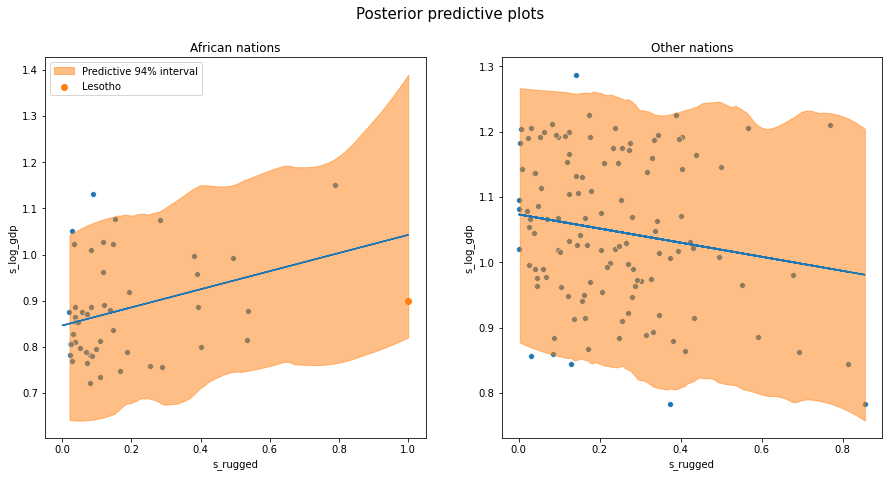

In [314]:
#Plot the posterior predictive intervals on the data


fig, axs = plt.subplots(1,2,figsize=(15,7))

fig.suptitle("Posterior predictive plots", fontsize=15)

x = Complete.s_rugged.values

sns.scatterplot(x="s_rugged", y="s_log_gdp", data=Complete[Complete.cont_africa==1], ax=axs[0])
#get the average posterior
mu1 = m8_3_samples["alpha"][:,1] + np.outer(x-0.215,m8_3_samples["beta"][:,1])
axs[0].plot(x, np.mean(mu1,axis=1))
az.plot_hpd(
    Complete[Complete.cont_africa==1].s_rugged,
    m8_3_post_samples["l_gdp"].T[Complete.cont_africa==1].T,
    ax=axs[0],
    fill_kwargs={"alpha": 0.5, "label": "Predictive 94% interval"},
)
axs[0].set_title("African nations")
for i in big[big.cont_africa == 1].country.values:
    axs[0].scatter(big[big.country==i].s_rugged,big[big.country==i].s_log_gdp,label=i)
axs[0].legend()


sns.scatterplot(x="s_rugged", y="s_log_gdp", data=Complete[Complete.cont_africa==0], ax=axs[1])
x = Complete[Complete.cont_africa==0].s_rugged
mu2 = m8_3_samples["alpha"][:,0] + np.outer(x-0.215,m8_3_samples["beta"][:,0])
axs[1].plot(x, np.mean(mu2,axis=1))
az.plot_hpd(
    Complete[Complete.cont_africa==0].s_rugged,
    m8_3_post_samples["l_gdp"].T[Complete.cont_africa==0].T,
    ax=axs[1],
    fill_kwargs={"alpha": 0.5, "label": "Mean outcome 94% HPD"},
)
axs[1].set_title("Other nations")

plt.show()

The highest pareto k value occurs for Lesotho. At first glance, this may seem fairly surprising as it appears fairly closer to the mean than the point immediately to the left of it. However, the PSIS is averaged over the posterior, and the posterior is much broader for Letsotho than other points, as the sparsity of data means the typical log likelihood of this particular value will be quite small. But we don't have much data around this point, meaning we don't have a good out of sample estimate for points like Lesotho as it's so far away from the bulk of our data points, limiting our predictive power here.

Answer to b):

In [316]:
with pm.Model() as Robust_m8_3:
    alpha = pm.Normal("alpha", 1,0.1, shape = 2)#alpha prior
    beta = pm.Normal("beta", 1,0.3, shape = 2)#beta prior
    sigma = pm.Exponential("sigma", 1)
    mu = alpha[Complete.cont_africa] + beta[Complete.cont_africa]*(Complete.s_rugged - 0.215)
    l_gdp = pm.StudentT("l_gdp", nu =2,mu=mu, sd= sigma, observed=Complete.s_log_gdp)
    Robust_m8_3_samples = pm.sample(draws= 250, chains = 4)
    Robust_m8_3_post_samples = pm.sample_posterior_predictive(trace = m8_3_samples,samples= 100)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 3 seconds.
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/pymc3/sampling.py:1707: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


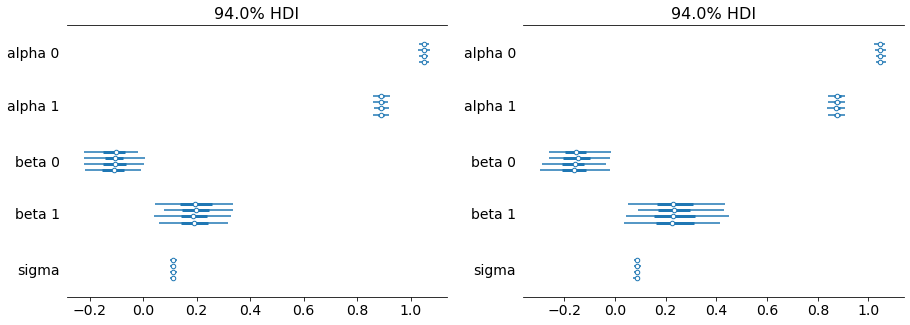

In [326]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].set_title("Standard Linear regression")
pm.forestplot(m8_3_samples, ax = axs[0])
axs[1].set_title("Robust Linear regression")
pm.forestplot(Robust_m8_3_samples, ax = axs[1])
plt.show()

These models are not spectacularly different from one another, that is, non of the data had a major impact on the parameter posteriors. The standard regression is on the left hand side whilst the robust regression is on the right hand side. There's been a marginal increase in the mean of the $\beta_1$ parameter of Africa. This is possibly becuase Lesotho is marginally less influential in the robust regression model as the mean line doesn't "dragged" around as much by this vaguely, weakly (not even really) extreme value.

/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for 

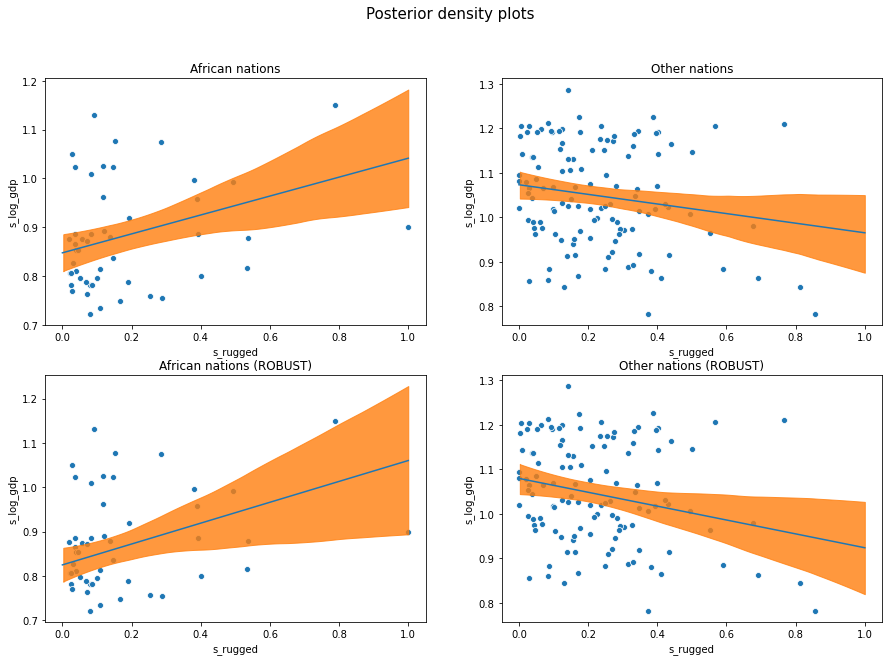

In [329]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

fig.suptitle("Posterior density plots", fontsize=15)

x = np.linspace(0,1)

sns.scatterplot(x="s_rugged", y="s_log_gdp", data=Complete[Complete.cont_africa==1], ax=axs[0,0])
#get the average posterior
mu1 = m8_3_samples["alpha"][:,1] + np.outer(x-0.215,m8_3_samples["beta"][:,1])
axs[0,0].plot(x, np.mean(mu1,axis=1))
az.plot_hpd(
    x,
    mu1.T,
    ax=axs[0,0],
    fill_kwargs={"alpha": 0.8, "label": "Mean outcome 94% HPD"},
)
axs[0,0].set_title("African nations")


sns.scatterplot(x="s_rugged", y="s_log_gdp", data=Complete[Complete.cont_africa==0], ax=axs[0,1])
mu2 = m8_3_samples["alpha"][:,0] + np.outer(x-0.215,m8_3_samples["beta"][:,0])
axs[0,1].plot(x, np.mean(mu2,axis=1))
az.plot_hpd(
    x,
    mu2.T,
    ax=axs[0,1],
    fill_kwargs={"alpha": 0.8, "label": "Mean outcome 94% HPD"},
)
axs[0,1].set_title("Other nations")



sns.scatterplot(x="s_rugged", y="s_log_gdp", data=Complete[Complete.cont_africa==1], ax=axs[1,0])
#get the average posterior
mu1 = Robust_m8_3_samples["alpha"][:,1] + np.outer(x-0.215,Robust_m8_3_samples["beta"][:,1])
axs[1,0].plot(x, np.mean(mu1,axis=1))
az.plot_hpd(
    x,
    mu1.T,
    ax=axs[1,0],
    fill_kwargs={"alpha": 0.8, "label": "Mean outcome 94% HPD"},
)
axs[1,0].set_title("African nations (ROBUST)")


sns.scatterplot(x="s_rugged", y="s_log_gdp", data=Complete[Complete.cont_africa==0], ax=axs[1,1])
mu2 = Robust_m8_3_samples["alpha"][:,0] + np.outer(x-0.215,Robust_m8_3_samples["beta"][:,0])
axs[1,1].plot(x, np.mean(mu2,axis=1))
az.plot_hpd(
    x,
    mu2.T,
    ax=axs[1,1],
    fill_kwargs={"alpha": 0.8, "label": "Mean outcome 94% HPD"},
)
axs[1,1].set_title("Other nations (ROBUST)")

plt.show()

It's literally so difficult to tell the difference by eye here.

8H4. The values in data(nettle) are data on language diversity in 74 nations.143 The meaning of
each column is given below.

(1) country: Name of the country

(2) num.lang: Number of recognized languages spoken

(3) area: Area in square kilometers

(4) k.pop: Population, in thousands

(5) num.stations: Number of weather stations that provided data for the next two columns

(6) mean.growing.season: Average length of growing season, in months

(7) sd.growing.season: Standard deviation of length of growing season, in months

Use these data to evaluate the hypothesis that language diversity is partly a product of food security. The notion is that, in productive ecologies, people don’t need large social networks to buffer them
against risk of food shortfalls. This means cultural groups can be smaller and more self-sufficient,
leading to more languages per capita. Use the number of languages per capita as the outcome:


In [330]:
"""
d$lang.per.cap <- d$num.lang / d$k.pop    (#citing the R code. Will use python)
"""

'\nd$lang.per.cap <- d$num.lang / d$k.pop    (#citing the R code. Will use python)\n'

Use the logarithm of this new variable as your regression outcome. (A count model would be better here, but you’ll learn those later, in Chapter 11.) This problem is open ended, allowing you to
decide how you address the hypotheses and the uncertain advice the modeling provides. If you
think you need to use WAIC anyplace, please do. If you think you need certain priors, argue for
them. If you think you need to plot predictions in a certain way, please do. Just try to honestly
evaluate the main effects of both mean.growing.season and sd.growing.season, as well as their
two-way interaction. Here are three parts to help. (a) Evaluate the hypothesis that language diversity,
as measured by log(lang.per.cap), is positively associated with the average length of the growing season, mean.growing.season. Consider log(area) in your regression(s) as a covariate (not
an interaction). Interpret your results. (b) Now evaluate the hypothesis that language diversity is
negatively associated with the standard deviation of length of growing season, sd.growing.season.
This hypothesis follows from uncertainty in harvest favoring social insurance through larger social
networks and therefore fewer languages. Again, consider log(area) as a covariate (not an interaction). Interpret your results. (c) Finally, evaluate the hypothesis that mean.growing.season and
sd.growing.season interact to synergistically reduce language diversity. The idea is that, in nations
with longer average growing seasons, high variance makes storage and redistribution even more important than it would be otherwise. That way, people can cooperate to preserve and protect windfalls
to be used during the droughts.

In [333]:
nettle = pd.read_csv("./data/nettle.csv", delimiter=";")

In [335]:
nettle["lang_per_cap"] = nettle["num.lang"]/nettle["k.pop"]

# Answer: Very open ended. Don't have time right now

8H5. Consider the data(Wines2012) data table. These data are expert ratings of 20 different French
and American wines by 9 different French and American judges. Your goal is to model score, the
subjective rating assigned by each judge to each wine. I recommend standardizing it. In this problem,
consider only variation among judges and wines. Construct index variables of judge and wine and
then use these index variables to construct a linear regression model. Justify your priors. You should
end up with 9 judge parameters and 20 wine parameters. How do you interpret the variation among
individual judges and individual wines? Do you notice any patterns, just by plotting the differences?
Which judges gave the highest/lowest ratings? Which wines were rated worst/best on average?

In [9]:
wine = pd.read_csv("./data/Wines2012.csv",delimiter=";")

In [10]:
wine

,judge,flight,wine,score,wine.amer,judge.amer
0,Jean-M Cardebat,white,A1,10.0,1,0
1,Jean-M Cardebat,white,B1,13.0,1,0
2,Jean-M Cardebat,white,C1,14.0,0,0
3,Jean-M Cardebat,white,D1,15.0,0,0
4,Jean-M Cardebat,white,E1,8.0,1,0
...,...,...,...,...,...,...
175,Francis Schott,red,F2,12.0,1,1
176,Francis Schott,red,G2,15.0,0,1
177,Francis Schott,red,H2,16.0,1,1
178,Francis Schott,red,I2,7.0,1,1


In [11]:
np.min(wine.score), np.max(wine.score), np.mean(wine.score)

(7.0, 19.5, 14.2)

In [12]:
#turn these wordy categories into numbers we can work with
wine.judge = pd.Categorical(wine.judge)
wine["judge_index"] = wine.judge.cat.codes

wine.wine = pd.Categorical(wine.wine)
wine["wine_index"] = wine.wine.cat.codes

In [13]:
wine

,judge,flight,wine,score,wine.amer,judge.amer,judge_index,wine_index
0,Jean-M Cardebat,white,A1,10.0,1,0,3,0
1,Jean-M Cardebat,white,B1,13.0,1,0,3,2
2,Jean-M Cardebat,white,C1,14.0,0,0,3,4
3,Jean-M Cardebat,white,D1,15.0,0,0,3,6
4,Jean-M Cardebat,white,E1,8.0,1,0,3,8
...,...,...,...,...,...,...,...,...
175,Francis Schott,red,F2,12.0,1,1,1,11
176,Francis Schott,red,G2,15.0,0,1,1,13
177,Francis Schott,red,H2,16.0,1,1,1,15
178,Francis Schott,red,I2,7.0,1,1,1,17


In [14]:
wine["wine_index"].drop_duplicates().shape, wine["judge_index"].drop_duplicates().shape 

((20,), (9,))

Let's scale the score in the wine model such that min = 0 and max = 1

In [15]:
wine["s_score"] = (wine.score - np.min(wine.score))/(np.max(wine.score)-np.min(wine.score))#scale the

Let's turn the wine scores into z-scores.

In [16]:
wine["s_score"] = (wine.score - np.mean(wine.score))/np.std(wine.score)

In [17]:
wine.wine_index

0       0
1       2
2       4
3       6
4       8
       ..
175    11
176    13
177    15
178    17
179    19
Name: wine_index, Length: 180, dtype: int8

In [18]:
wine.columns

Index(['judge', 'flight', 'wine', 'score', 'wine.amer', 'judge.amer',
       'judge_index', 'wine_index', 's_score'],
      dtype='object')

Text(0, 0.5, 'Wine Score')

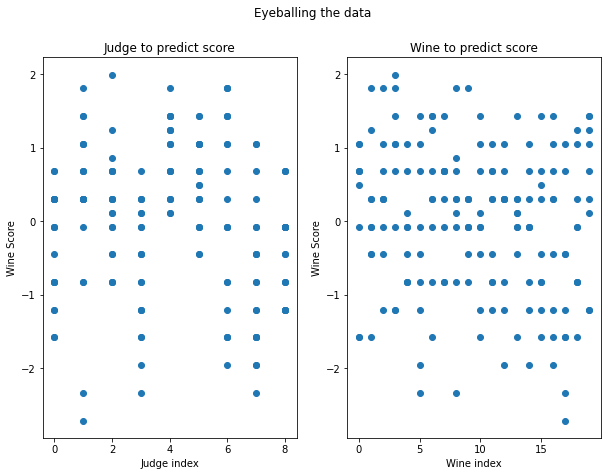

In [19]:
fig, axs = plt.subplots(1,2, figsize=(10,7))

plt.suptitle("Eyeballing the data")

axs[0].scatter(wine.judge_index,wine["s_score"])
axs[0].set_title("Judge to predict score")
axs[0].set_xlabel("Judge index")
axs[0].set_ylabel("Wine Score")

axs[1].scatter(wine.wine_index,wine["s_score"])
axs[1].set_title("Wine to predict score")
axs[1].set_xlabel("Wine index")
axs[1].set_ylabel("Wine Score")



As can be seen from the above data, knowing the wine by itself doesn't seem to obviously narrow down what you'd expect to see in the data. However, know which judge you have might be useful information. As seen for judges 4 and 6, you might expect any generic wine that you give them to get an above average rating. They've sampled 20 wines, which isn't a phenomenal amount, but it should be enough to do some inference. But perhaps the model shouldn't get too excited by the data, as maybe there's some other magic variable determining what's going on with those "overly positive" judges. Maybe thye just won the lottery. In future they might have a bad day, in which case they'd be the opposite. So I'll use a model

Let's define our linear model in this instance. Let's make a DAG to go with it to help aid our interpretation of what we're actually doing. The model proposed in the question presumes that score is "caused" by some combination of score and 

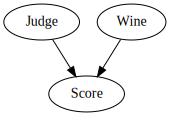

In [20]:
from causalgraphicalmodels import CausalGraphicalModel

Dag = CausalGraphicalModel(
    nodes=["Judge","Wine","Score"],
    edges=[
        ("Judge","Score"),
        ("Wine", "Score")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render

Dag.draw()

And we give it this regression model, and add Gaussian noise around the middle

$\mu_i = \alpha_{CIV[i]} + \beta_{CIV[i]}$

Where $\alpha$ is the effect of being a certain judge, and $\beta$ is the effect of being a certain wine on the score outcome. We assume no interaction in the model at this point

# Check this interpretation of parameters

Basically we have categorical inputs to help us predict the score. As we're using this to predict Z-scores, I think the correct interpretation of what each of these parameters is saying is as follows: $\mu_i = \alpha_{CIV[i]} + \beta_{CIV[i]}$ tells us the mean score that we'd expect to see given that we know that the relevant judges and wines went into producing the score. The categorical indicators would be zero for any wine or judge not in our model, or if you simply decline to tell the model who the judge is or what the wine is. Thus I interpret any $\alpha$ parameter to be the mean value the model would take on given that the model knows nothing about the wine, and vis versa for the $\beta$ parameters, when the model doesn't know who is judging, but does know the wine.

In [21]:
wine.groupby("wine").mean()["s_score"].std(), wine.groupby("judge").mean()["s_score"].std()

(0.3391405978089046, 0.5568056851777015)

Given these interpretations and the scatter plots above, we now have the task of assigning priors. Judging from the scatters, the mean for any candidate should be around zero. I could assign poorly formed, broad priors of around 2. This means that you'd expect about 33% (see 67-95-99 rule) of the judges to assign to have mean Z-scores of more than 2. This is proposterously large. Even using 1 here seems silly. Looking at the code above, we can see that the standard deviation in the average score of the each wine, is 0.33 and of the judges is around 0.55. These are more informed priors (maybe I somehow double counted by forming a prior in this way). It seems plausible the knowing the judge is more informative than the wine itself. I'll use these as weakly "regularizing" priors

I'll run two models, one with std of one on the priors and another with the regularization and compare them to see what comes out of the other side.

As these are z scores, we expect a maximum standard deviation of around 1 given that we knew nothing else about the data. For obvious information theoretic reasons, the data cannot become more dispersed on average once we know the wine or the judge. At worst the wine and judge can be independent of the score, in which case we're just guessing z-scores at random. This places an upper bound on our expectations of the noise about $\mu$. To encode this in the model, we can just make sigma ~ Exp(1).

I'm also throwing in an "over-regularized" model just to see what happens. Basically, I'm just putting unreasonably narrow priors on the degree alpha and beta parameters.

In [22]:
with pm.Model() as wine_score:
    alpha = pm.Normal("alpha", 0,1,shape=(9))
    beta = pm.Normal("beta", 0,1,shape=(20))
    sigma = pm.Exponential("sigma", 1)
    mu = alpha[wine.judge_index]  + beta[wine.wine_index,]
    wine_score = pm.Normal("wine_score", mu=mu, sd=sigma, observed=wine.s_score)
    wine_post = pm.sample(draws = 1000, chains=4)
    
with pm.Model() as regularized_wine_score:
    alpha = pm.Normal("alpha", 0,0.55,shape=(9))
    beta = pm.Normal("beta", 0,0.33,shape=(20))
    sigma = pm.Exponential("sigma", 1)
    mu = alpha[wine.judge_index]  + beta[wine.wine_index,]
    regularized_wine_score = pm.Normal("wine_score", mu=mu, sd=sigma, observed=wine.s_score)
    regularized_wine_post = pm.sample(draws = 1000, chains=4)
    
with pm.Model() as over_regularized_wine_score:
    alpha = pm.Normal("alpha", 0,0.1,shape=(9))
    beta = pm.Normal("beta", 0,0.1,shape=(20))
    sigma = pm.Exponential("sigma", 1)
    mu = alpha[wine.judge_index]  + beta[wine.wine_index,]
    over_regularized_wine_score = pm.Normal("wine_score", mu=mu, sd=sigma, observed=wine.s_score)
    over_regularized_wine_post = pm.sample(draws = 1000, chains=4)

INFO (theano.gof.compilelock): Refreshing lock /home/aidan/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.10-x86_64-3.8.5-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [23]:
compare_df = az.compare(
    {"wine_score": wine_post, "regularized_wine_score": regularized_wine_post,"over_regularized_wine_score": over_regularized_wine_post},
    ic="waic",
    scale="deviance"
)
compare_df

/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:1413: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
regularized_wine_score,0,472.257,19.0243,0,0.936798,18.8941,0,True,deviance
wine_score,1,481.526,25.1336,9.26862,0.0503522,19.4595,4.45146,True,deviance
over_regularized_wine_score,2,498.516,4.09224,26.2589,0.0128495,17.6057,10.5139,False,deviance


As can be seen, my sensiblish model performed best, the stupid broad priors come in second place, whilst the over regularized model does real bad. This suggests that my informed regularization worked as intended. The overregularized model essentially just refuses to believe that know the wine or the judge is in anyway helpful for knowing the score, in spite of evidence to the contrary, hence it will make poor predictions about future, out of sample data.

In [24]:
alpha_summary = pm.summary(regularized_wine_post,var_names=["alpha"])
beta_summary = pm.summary(regularized_wine_post,var_names=["beta"])

/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [25]:
#make hacky data frames to use in the middle
tempdf = wine[["judge_index","judge.amer"]].drop_duplicates().sort_values(by=["judge_index"])
tempdf2 = wine[["wine_index","wine.amer"]].drop_duplicates().sort_values(by=["wine_index"])

In [26]:
#match up the wine and judges with their associated effect size
tempdf["judge_effect"] = alpha_summary["mean"].values
tempdf2["wine_effect"] = beta_summary["mean"].values

We now have data frames matching the judges and wine scores as to whether or not they're American

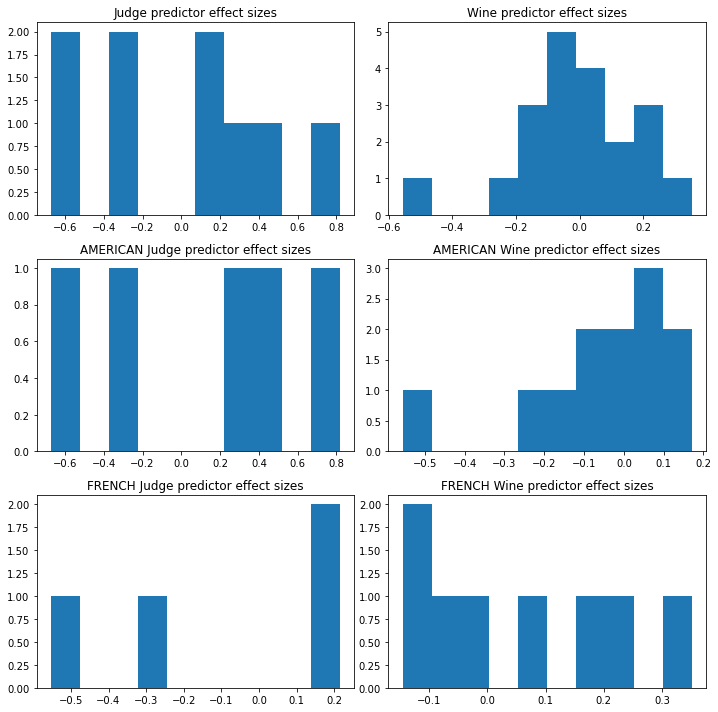

In [27]:
fig, axs = plt.subplots(3,2,figsize=(10,10))

axs[0,0].hist(alpha_summary["mean"])
axs[0,0].set_title("Judge predictor effect sizes")

axs[0,1].set_title("Wine predictor effect sizes")
axs[0,1].hist(beta_summary["mean"])



axs[1,0].hist(tempdf[tempdf["judge.amer"] == 1].judge_effect)
axs[1,0].set_title("AMERICAN Judge predictor effect sizes")

axs[1,1].set_title("AMERICAN Wine predictor effect sizes")
axs[1,1].hist(tempdf2[tempdf2["wine.amer"] == 1].wine_effect)



axs[2,0].hist(tempdf[tempdf["judge.amer"] == 0].judge_effect)
axs[2,0].set_title("FRENCH Judge predictor effect sizes")

axs[2,1].set_title("FRENCH Wine predictor effect sizes")
axs[2,1].hist(tempdf2[tempdf2["wine.amer"] == 0].wine_effect)

plt.tight_layout()

As can be sen here there's a fairly broad dispersion in effect sizes for the judges. Some having hugely positive and some having hugely negative tendancies for their scoring. The wine however appears to be fairly tightly clustered around zero. This indicates the score is more determined by the judges than by the wine. There is however one quite negative outlier. A plausible explanation is that most wines are in fact fairly similar to each other, but truly awful wine commands agreement amongst the judges for the producing a very low score. Entertainingly, the very bad wine is American.
There's vague tendancy for both American wines and judges to have a considerable range of predictive powers in the models. In general the french wines appear to have a slightly positive predictive effect on the score in this model. But these are all tiny and there doesn't appear to be too much information contained within the model here.

8H6. Now consider three features of the wines and judges:

(1) flight: Whether the wine is red or white.

(2) wine.amer: Indicator variable for American wines.

(3) judge.amer: Indicator variable for American judges.

Use indicator or index variables to model the influence of these features on the scores. Omit the
individual judge and wine index variables from Problem 1. Do not include interaction effects yet.
Again justify your priors. What do you conclude about the differences among the wines and judges?
Try to relate the results to the inferences in the previous problem.

I'm presuming something broadly like the model that's shown below, where WN is wine nationality, JN is judge nationality, and f is the "flight".

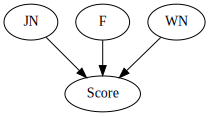

In [28]:
from causalgraphicalmodels import CausalGraphicalModel

Dag = CausalGraphicalModel(
    nodes=["JN","WN", "F","Score"],
    edges=[
        ("JN","Score"),
        ("WN", "Score"),
        ("F", "Score")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render

Dag.draw()

In [31]:
wine.flight.Cat

The regression model this time looks something like $\mu_i = \alpha_{CIV[i]} + \beta_{CIV[i]} + \gamma_{CIV[i]}$

where $\alpha, \beta, \gamma$ are the effect sizes for JN, WN, and F respectively, each being index variables, because the effect size depends on whether or not you're American.

Putting priors onto this model is challenging. The same information theoretic  argument regarding the noise around $\mu$ from last time holds here. It's hard to imagine that the mean score conditional on these binary random variables could shift that substantially away from the mean. Inspecting the data we can get a rough idea of the effect sizes we'd expect (AGAIN, I think this could be a completely illegitimate way actually form priors). I'm going to use N(0,0.1) as my prior on all of these index variables.

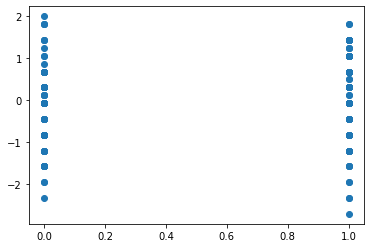

In [33]:
plt.scatter(wine["judge.amer"], wine["s_score"])

In [34]:
wine.flight = pd.Categorical(wine.flight)
wine["flight_index"] = wine.flight.cat.codes

In [35]:
wine.groupby("judge.amer").s_score.mean(), wine.groupby("wine.amer").s_score.mean(), wine.groupby("flight_index").s_score.mean()

(judge.amer
 0   -0.138808
 1    0.111047
 Name: s_score, dtype: float64,
 wine.amer
 0    0.115543
 1   -0.077029
 Name: s_score, dtype: float64,
 flight_index
 0   -0.002091
 1    0.002091
 Name: s_score, dtype: float64)

In [41]:
with pm.Model() as other_wine_score:
    alpha = pm.Normal("alpha", 0,0.1,shape=(2))
    beta = pm.Normal("beta", 0,0.1,shape=(2))
    gamma = pm.Normal("gamma", 0,0.1,shape=(2))
    sigma = pm.Exponential("sigma", 1)
    mu = alpha[wine["judge.amer"]] + beta[wine["wine.amer"]] + gamma[wine.flight_index]
    wine_score = pm.Normal("wine_score", mu=mu, sd=sigma, observed=wine.s_score)
    other_wine_post = pm.sample(draws = 1000, chains=4,cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, gamma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [ ]:
pm.summary(wine_post)

These predictor variables have 97% compatability intervals which surround 0 effect size, indicating there isn't a whole lot of predictive power in knowing these binary variables. This is seen further in that the mean sigma in this model is precisely one, the maximum value that it would take if z scores and these binary random variables were completely independent of one another. To summarise, this model, left as is, is terrible, matching expections found from our previous model.

8H7. Now consider two-way interactions among the three features. You should end up with three
different interaction terms in your model. These will be easier to build, if you use indicator variables.
Again justify your priors. Explain what each interaction means. Be sure to interpret the model’s
predictions on the outcome scale (mu, the expected score), not on the scale of individual parameters.
You can use link to help with this, or just use your knowledge of the linear model instead. What do
you conclude about the features and the scores? Can you relate the results of your model(s) to the
individual judge and wine inferences from 8H5?

Using the indicator variables for this is challenging. It seems plausible that people would have a bias for or against wine from their own country. I don't really see how the nationality of a wine and it's colour would interact. I'm going to imagine that white french wines would get bonus points, as they're particularly good, and further more that French judges have a preference for white wines. I cannot imagine that these effects are large. They're encoded into the model in the following way: 


$\mu_i = \alpha_{CIV[i]} + \beta_{CIV[i]} + \gamma_{CIV[i]} + \phi_{(J,W)} \mathbb{1}_{(JN=WN)}  + \phi{(W,F) }\mathbb{1}_{(JN=0 \cap F=W)} + \phi_{(W,F)} \mathbb{1}_{(W=0 \cap F=W)} $

These indicator functions encode mean the interaction only kicks in when the data is in the required sets as outlined above and the $\phi$ terms encode the size of the interactions. I imagine these effect size to be small, but I'm still open minded so use the prior N(0,0.2).

In [ ]:
wine

In [ ]:
#create the features for the indicator functions
cond0 = (wine["wine.amer"] == wine["judge.amer"])+0 #american wine and american judge
cond1 = (wine["judge.amer"] == 0) & (wine.flight_index ==1) #french judge and white wine
cond2 = (wine["wine.amer"] == 0) & (wine.flight_index ==1) #french wine and white wine

In [ ]:
#write this interaction model

with pm.Model() as Interacting_wine_score:
    alpha = pm.Normal("alpha", 0,0.1,shape=(2))
    beta = pm.Normal("beta", 0,0.1,shape=(2))
    gamma = pm.Normal("gamma", 0,0.1,shape=(2))
    phi = pm.Normal("phi", 0,0.2,shape=(3))
    sigma = pm.Exponential("sigma", 1)
    
    mu = alpha[wine["judge.amer"]] + beta[wine["wine.amer"]] + gamma[wine.flight_index] + phi[0]*cond0 + phi[1]*cond1 + phi[2]*cond2
    wine_score = pm.Normal("wine_score", mu=mu, sd=sigma, observed=wine.s_score)
    interacting_wine_post = pm.sample(draws = 1000, chains=4)

In [ ]:
pm.summary(interacting_wine_post)

All of these effects are tiny!

In [ ]:
#let's compare all of the models
compare_df = az.compare(
    {"wine_score": wine_post, "regularized_wine_score": regularized_wine_post,"over_regularized_wine_score": over_regularized_wine_post,
    "other_wine_score": other_wine_post, "Interacting_wine_score": interacting_wine_post},
    ic="waic",
    scale="deviance"
)
compare_df

These other models do wayyy worse than the original froms the earier model. These interactions terms beween the nationality of the wine and the judge etc, just don't have much of an overall effect on how everything goes.

In summary, having a model with 20 parameters can get a lot more predictive power of the Z-score than some noddy interaction model. Something like the persona of a judge and the character of the wine form a more predictive model than nationalistic tendancies.